# Analyze a Sparse Grid Run

In [2]:
import os
import numpy as np
import xarray as xr
import cftime
import pandas as pd
import glob
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [3]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

In [4]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

<Client: 'tcp://128.117.208.179:44641' processes=0 threads=0, memory=0 B>

## Set Up

First specify history variables and variables to investigate

In [5]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 'QVEGE',
              'QVEGT', 'EFLX_LH_TOT', 'FSH', 'FSR', 'FSDS', 'FSA',
              'FIRE', 'FLDS', 'FCTR', 'FCEV', 'FGEV', 'BTRANMN',
              'FGR', 'SOILWATER_10CM', 'TWS', 'QRUNOFF', 'SNOWDP',
              'TV', 'TG', 'TSA', 'TBOT']

clm_vars = ['FPSN', 'TLAI', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH',
            'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FCTR', 'FCEV',
            'FGEV', 'BTRANMN', 'FGR', 'SOILWATER_10CM', 'TWS',
            'QRUNOFF', 'SNOWDP', 'TV', 'TG', 'TSA', 'TBOT']

out_vars = ['GPP', 'LAI', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM', 'ASA',
            'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN', 'TV']

### Files Needed

In [6]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')


# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/scripts/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

# # ilamb observations
ilamb_config_file = '/glade/work/afoster/FATES_calibration/scripts/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

## Read in Datasets

In [7]:
# default sparse grid run
sparse_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_vai/lnd/hist'
sparse_ds = analysis.post_process_ds(sparse_dir, fates_vars, whittaker_ds,
                                     [2000, 2015], {'filter_nyears': 20})

In [8]:
# global sparse grid run
global_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_full/lnd/hist'
global_ds = analysis.post_process_ds(global_dir, fates_vars, whittaker_ds,
                                     [2000, 2015],
                                     {'sparse': False, 'filter_nyears': 20})

## Post-Process Datasets


### Temporal Averaging
First calculate annual and monthly means

In [54]:
# annual means
ann_means_sparse = analysis.apply_to_vars(sparse_ds, out_vars, func=analysis.calculate_annual_mean, add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars}).mean(dim='year')

ann_means_glob = analysis.apply_to_vars(global_ds, out_vars,
                                         func=analysis.calculate_annual_mean,
                                         add_sparse=False,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars},
                                         new_units={var: var_dict[var]["annual_units"] for var in out_vars}).mean(dim='year')

In [55]:
# monthly means
month_means_sparse = analysis.apply_to_vars(sparse_ds, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=True,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

month_means_glob = analysis.apply_to_vars(global_ds, out_vars,
                                         func=analysis.calculate_monthly_mean,
                                         add_sparse=False,
                                         conversion_factor={var: var_dict[var]["time_conversion_factor"] for var in out_vars})

### Calculate Month of Max
Calculate the month of the maximum variable

In [56]:
# month of max
max_month_sparse = analysis.apply_to_vars(month_means_sparse, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=True)

max_month_glob = analysis.apply_to_vars(month_means_glob, out_vars,
                                         func=lambda x: x.idxmax(dim="month"),
                                         add_sparse=False)

### Remap Sparse Grid

Remap the annual and monthly sparse means to a global grid

In [96]:
# maps from the annual means
sparse_glob = analysis.get_sparse_maps(ann_means_sparse, sparse_grid,
                                     out_vars)

# maps from the monthly maxes
sparse_glob_month_max = analysis.get_sparse_maps(max_month_sparse, sparse_grid,
                                     out_vars)

### Zonal Means
Calculate zonal means (by latitude)

In [58]:
# annual means
zonal_sparse = analysis.apply_to_vars(sparse_glob, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

zonal_global = analysis.apply_to_vars(ann_means_glob, out_vars,
                                         func=analysis.calculate_zonal_mean,
                                         add_sparse=False,
                                         land_area=target_grid.land_area,
                                         conversion_factor={var: var_dict[var]["area_conversion_factor"] for var in out_vars})

### Climatology
Calculate climatology

In [97]:
# area means from monthly
sparse_glob_monthly = analysis.get_sparse_area_means(month_means_sparse, 'global',
                                                out_vars, var_dict, land_area,
                                                sparse_ds.biome)

glob_monthly = analysis.get_area_means(month_means_glob, out_vars, var_dict,
                                       target_grid.land_area)

### Calculate Global Annual Values

Area-weighted averages

In [98]:
# sparse area means
area_means_sparse = analysis.get_sparse_area_means(ann_means_sparse,
                                            'global', out_vars,
                                            var_dict, land_area, sparse_ds.biome)

# global area means 
area_means_glob = analysis.get_area_means(ann_means_glob, out_vars, var_dict,
                                          target_grid.land_area)

## How Well the Does the Sparse Grid Match Global Simulations
### Annual Maps

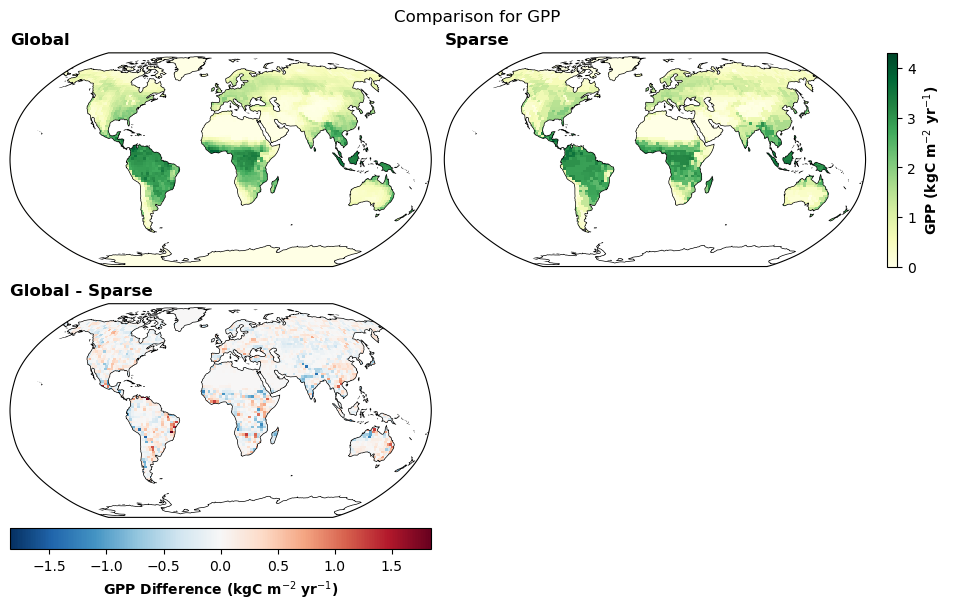

In [63]:
var = 'GPP'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

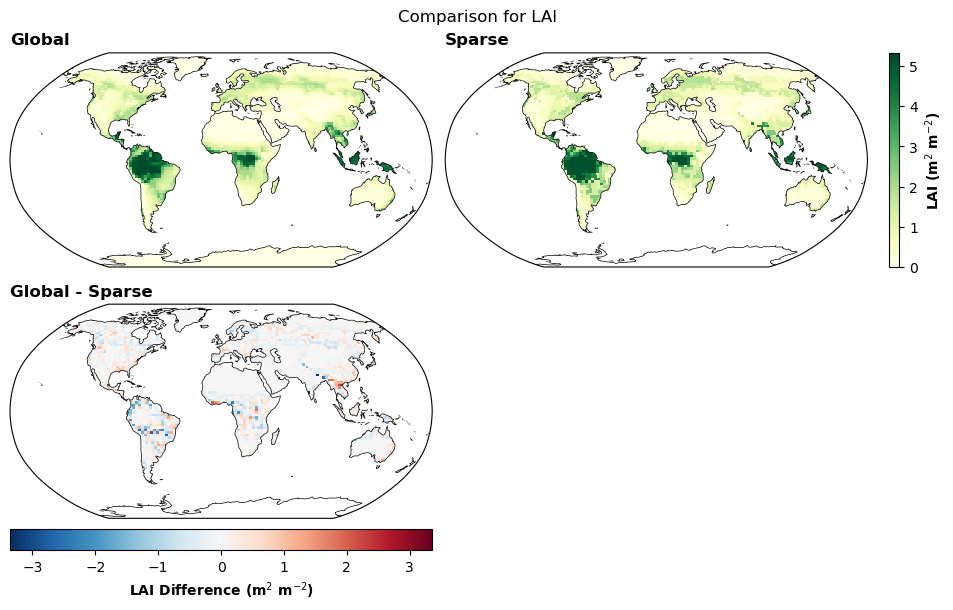

In [64]:
var = 'LAI'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

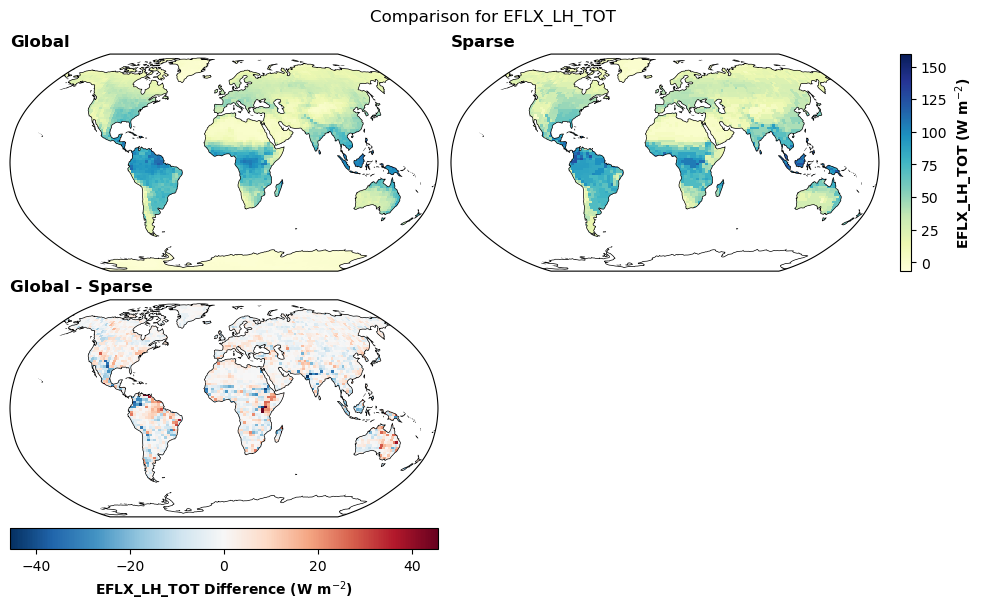

In [65]:
var = 'EFLX_LH_TOT'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

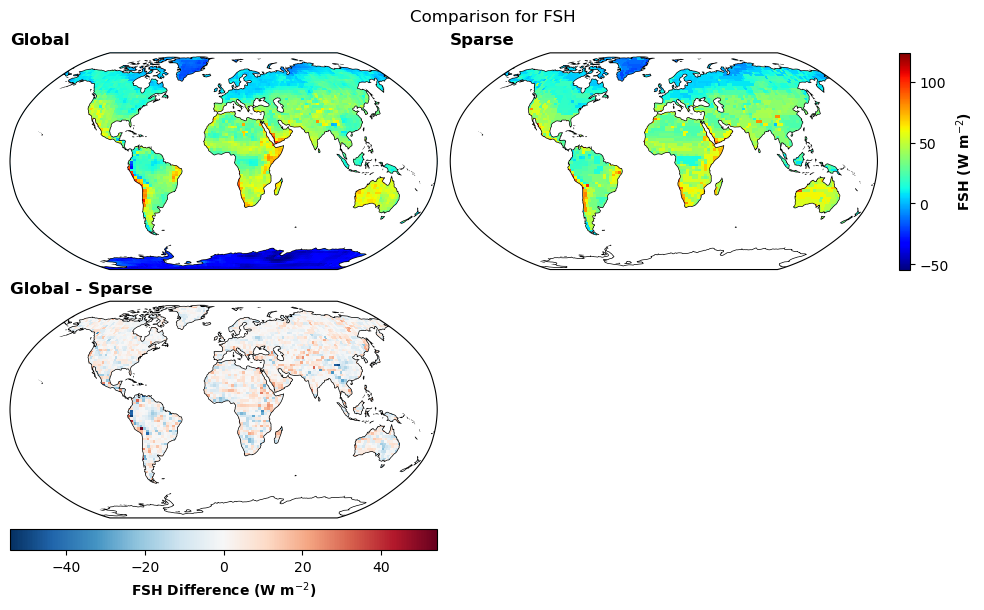

In [66]:
var = 'FSH'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

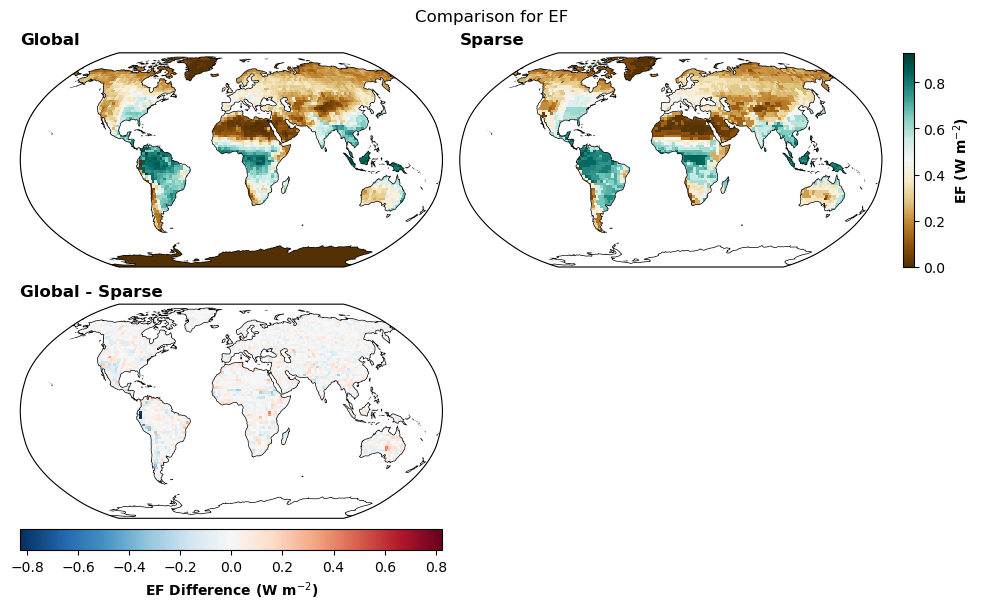

In [67]:
var = 'EF'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

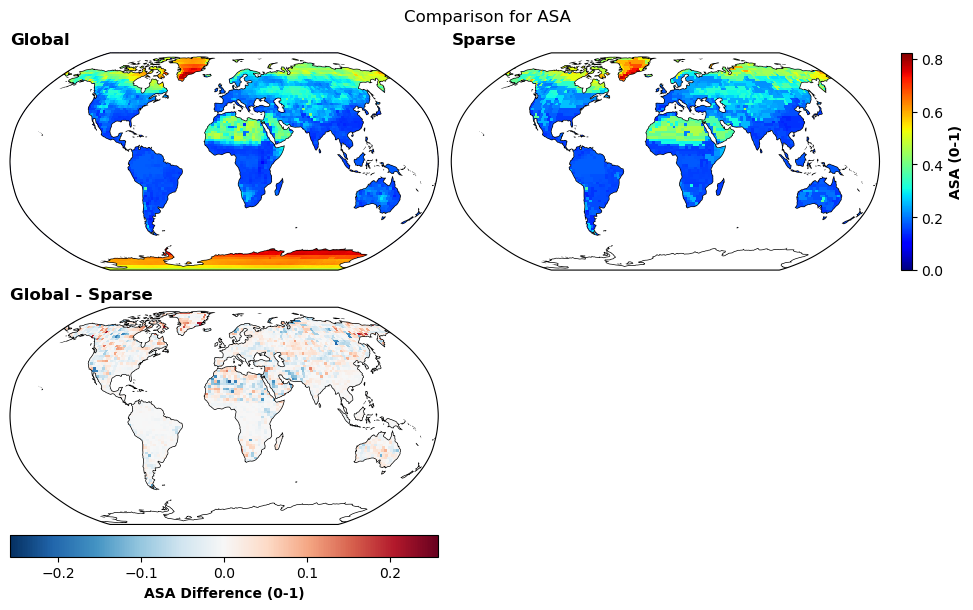

In [68]:
var = 'ASA'
plotting.plot_two_model_diff(sparse_glob[var], ann_means_glob[var], 'Sparse',
                             'Global', var, var_dict[var]['annual_units'],
                             var_dict[var]['cmap'])

### Zonal Means

### Month of Max

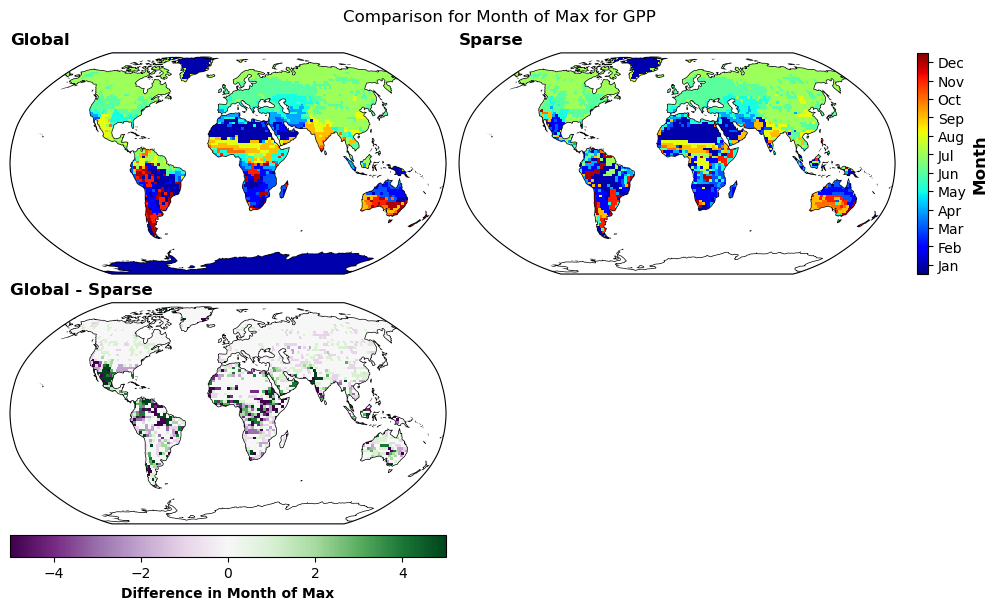

In [69]:
var = 'GPP'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

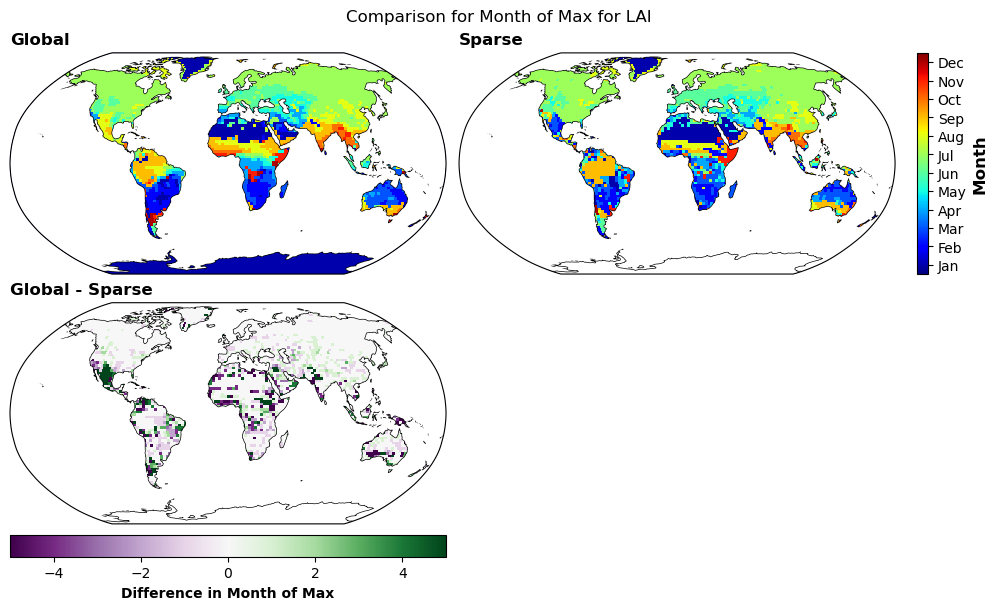

In [70]:
var = 'LAI'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var], 
                                max_month_glob[var], 'Sparse', 'Global', var)

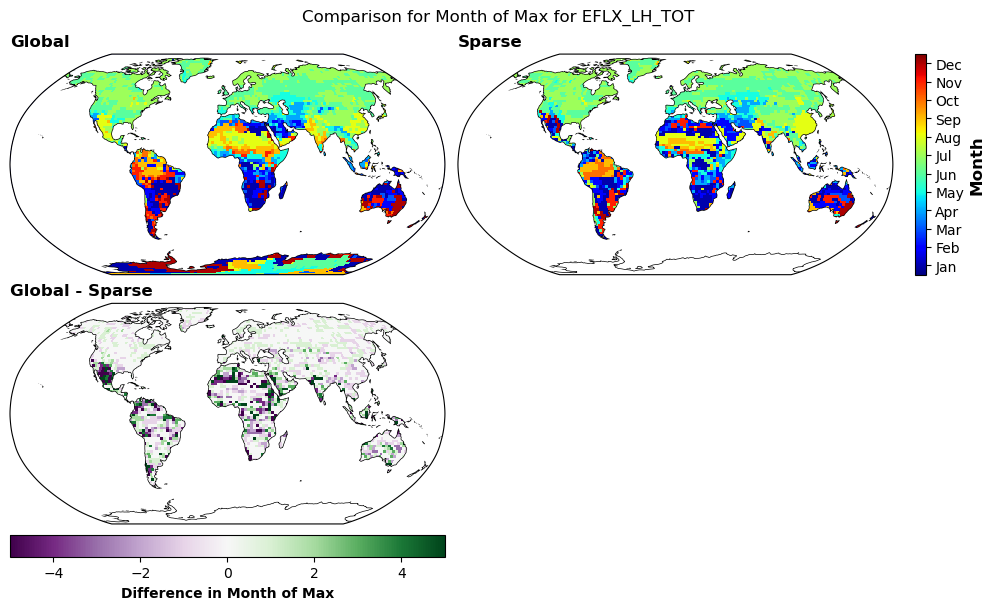

In [71]:
var = 'EFLX_LH_TOT'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

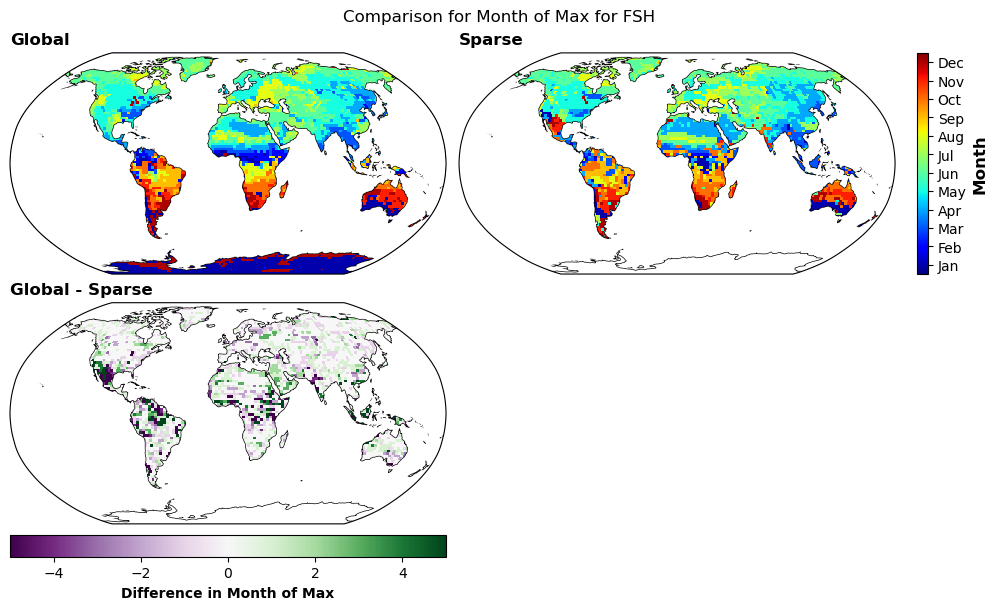

In [72]:
var = 'FSH'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

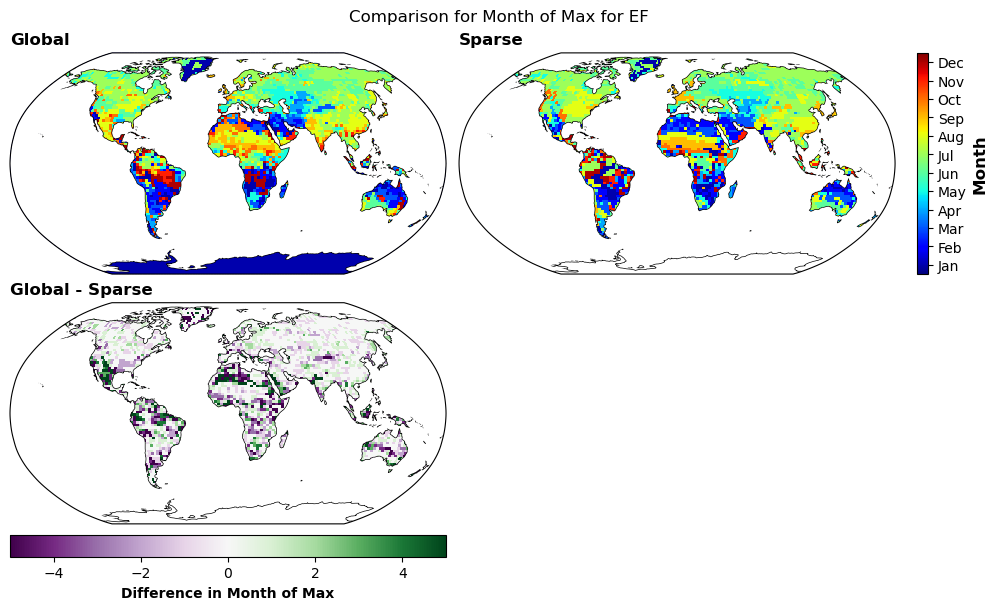

In [73]:
var = 'EF'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

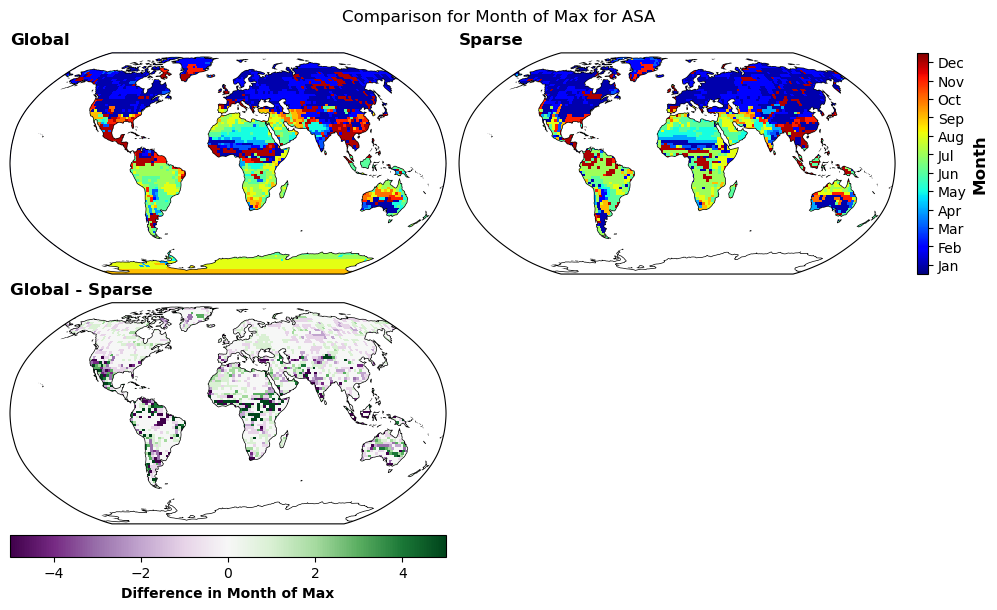

In [74]:
var = 'ASA'
plotting.plot_month_of_max_diff(sparse_glob_month_max[var],
                                max_month_glob[var], 'Sparse', 'Global', var)

### Climatology

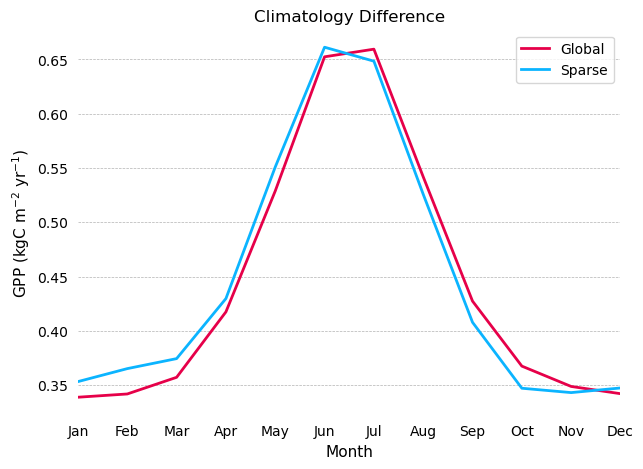

In [75]:
var = 'GPP'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

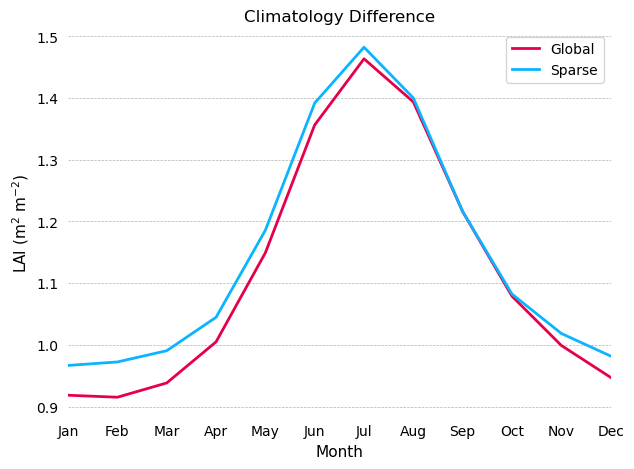

In [76]:
var = 'LAI'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

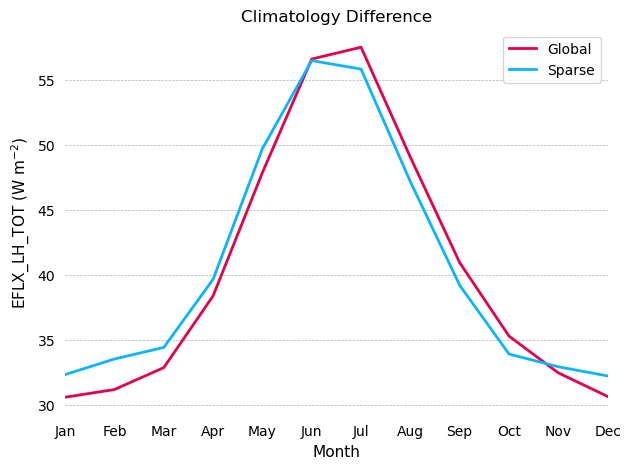

In [77]:
var = 'EFLX_LH_TOT'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

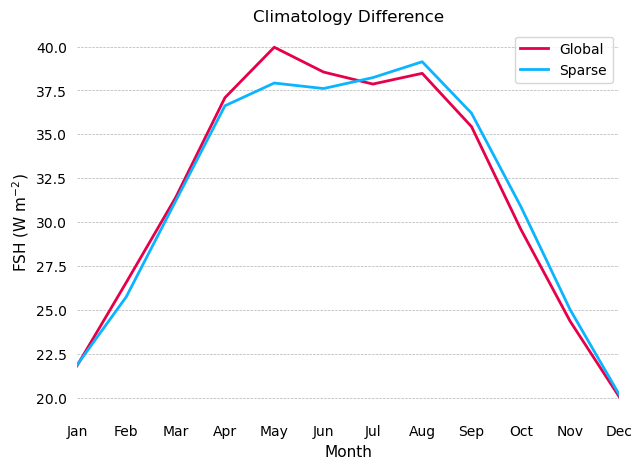

In [78]:
var = 'FSH'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

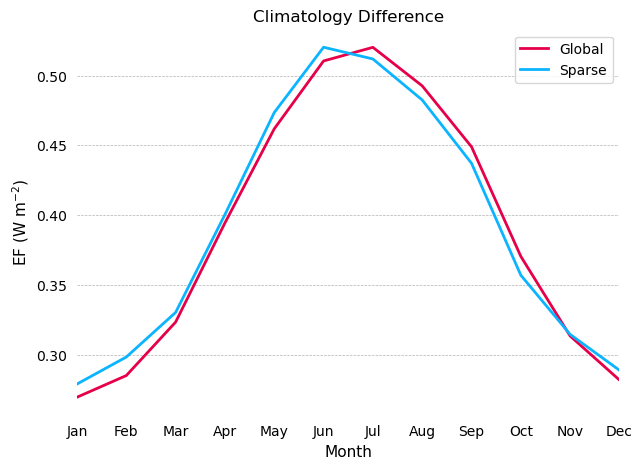

In [79]:
var = 'EF'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

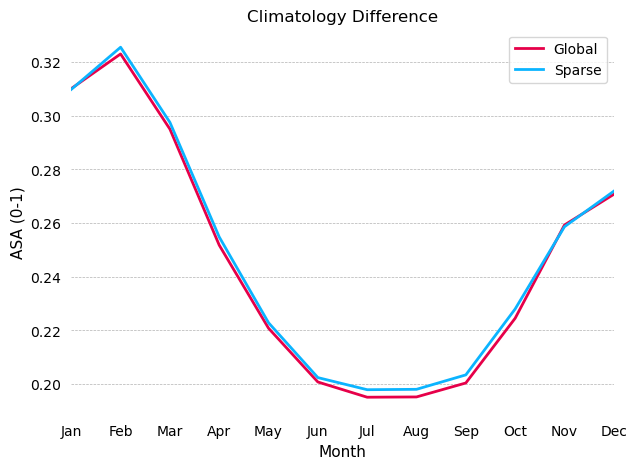

In [80]:
var = 'ASA'
plotting.plot_annual_cycle_diff(glob_monthly[var], sparse_glob_monthly[var],
                                "Global", "Sparse", var, var, var_dict[var]['annual_units'])

### Global Annual Values

In [81]:
summary_df = plotting.summarize_differences(area_means_glob, area_means_sparse,
                                            'Global', 'Sparse', var_dict)

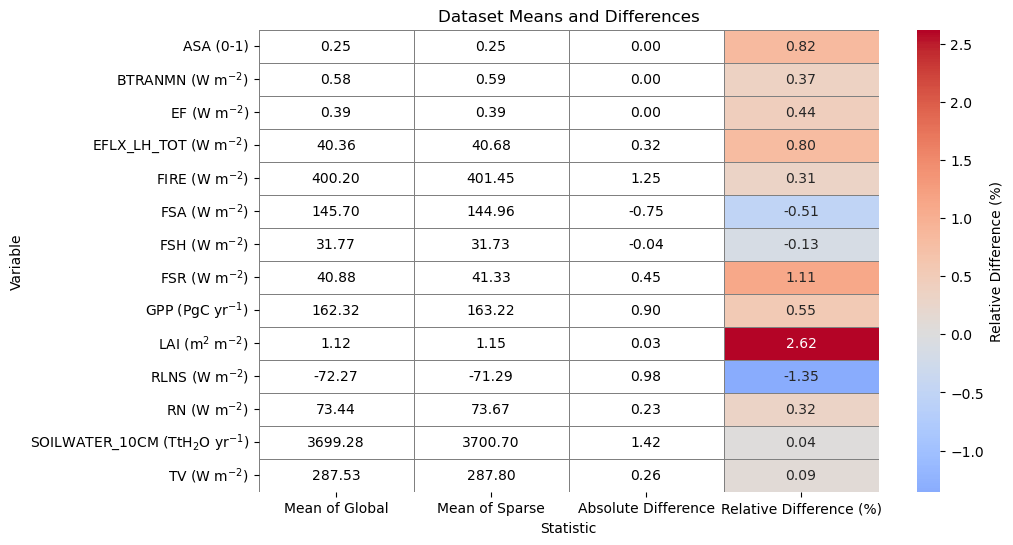

In [82]:
plotting.plot_heatmap(summary_df)

## Observational Comparisons
### Annual Maps

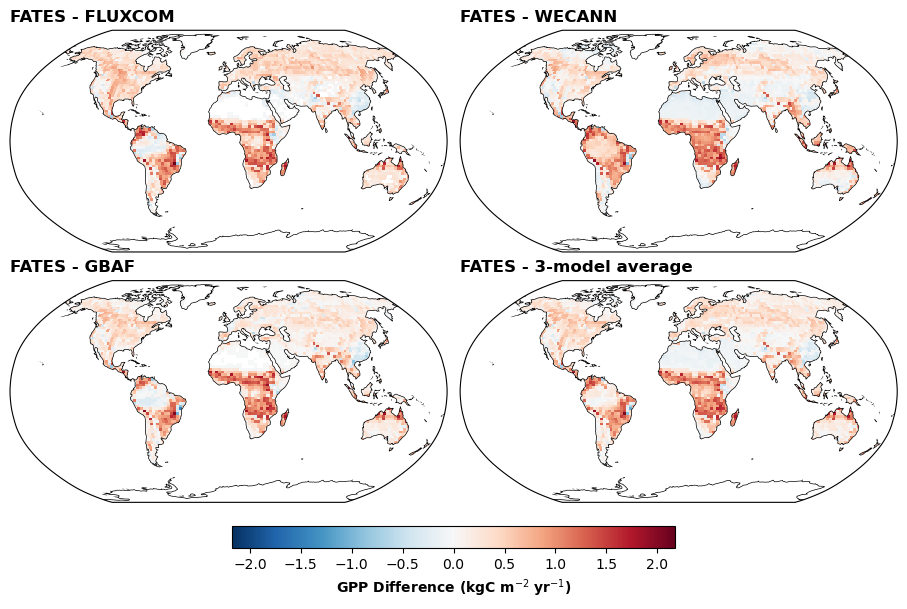

In [84]:
var = 'GPP'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

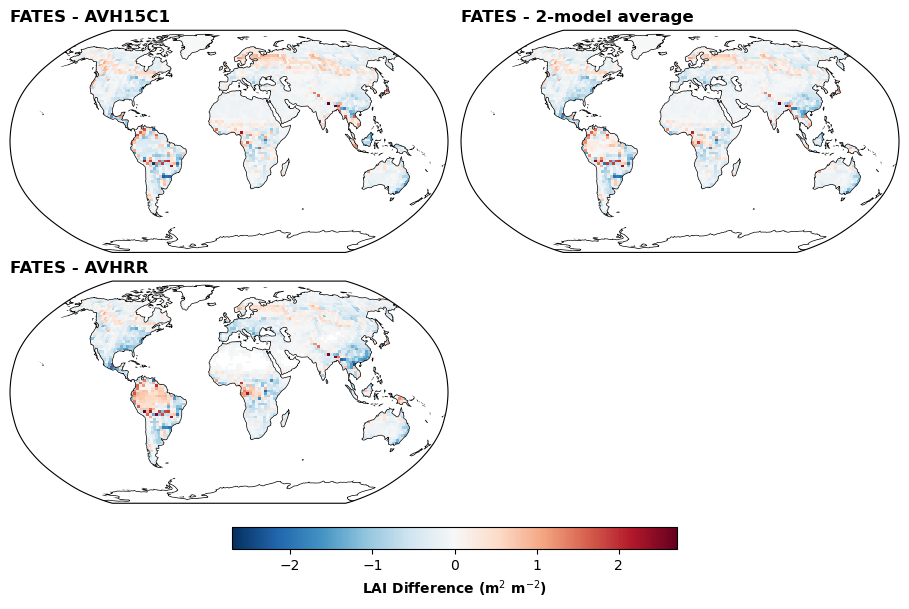

In [95]:
var = 'LAI'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var,
                             var_dict[var]['annual_units'], 'FATES')

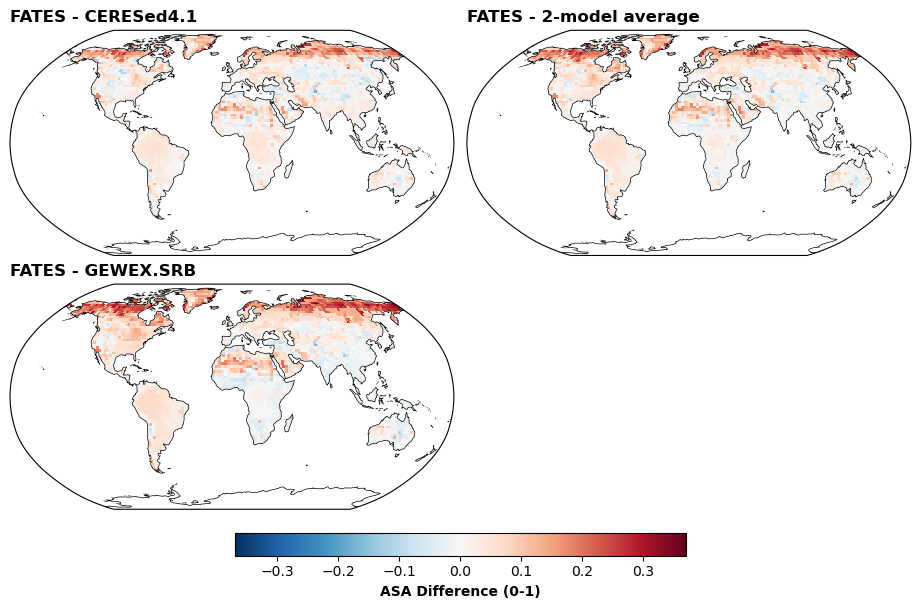

In [86]:
var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

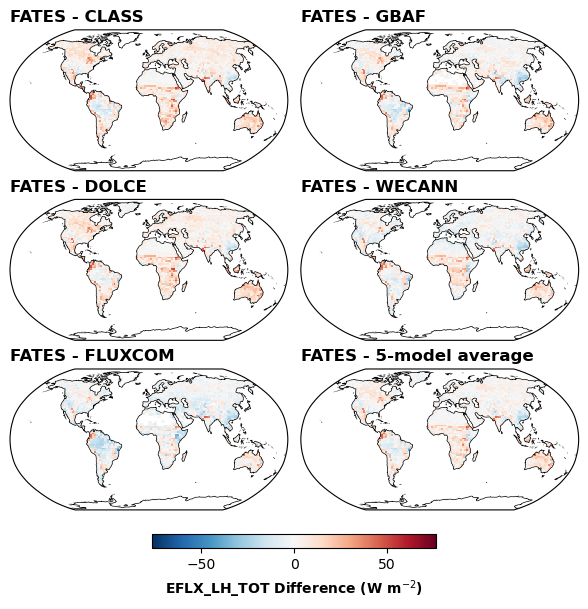

In [87]:
var = 'EFLX_LH_TOT'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

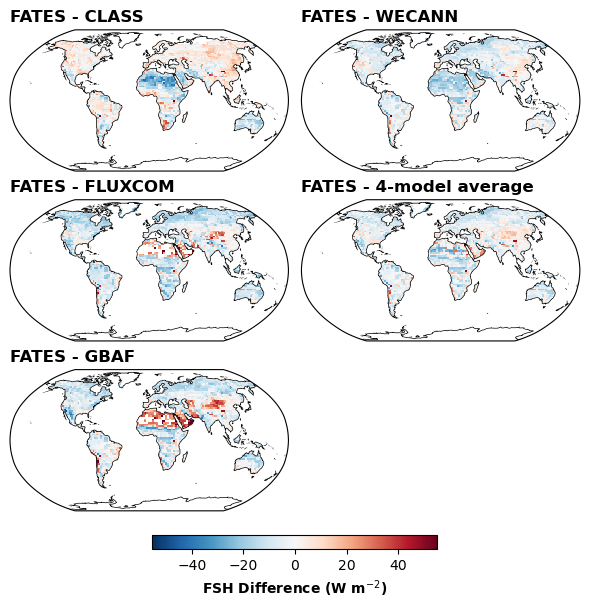

In [88]:
var = 'FSH'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

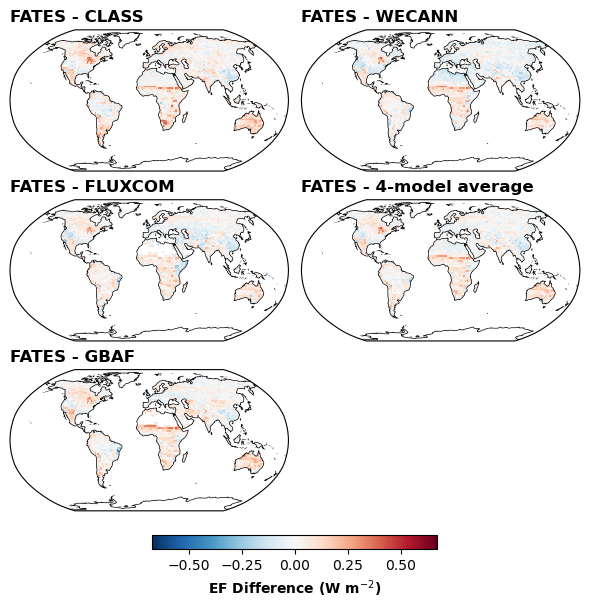

In [89]:
var = 'EF'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[var]['var'], ilamb_config[var]['models'])
plotting.plot_model_obs_diff(sparse_glob, ilamb_var, target_grid.landfrac, var, var_dict[var]['annual_units'], 'FATES')

In [94]:
import importlib
import fates_calibration_library.plotting_functions
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)
importlib.reload(fates_calibration_library.plotting_functions)

<module 'fates_calibration_library.plotting_functions' from '/glade/work/afoster/FATES_calibration/scripts/fates_calibration_library/plotting_functions.py'>